# Učitavanje train, valid, test skupova meta-podataka

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [316]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [276]:
import pandas as pd
trainValDf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/nih-chest-x-ray-train.csv', sep=',', index_col=0)
testDf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/nih-chest-x-ray-test.csv', sep=',', index_col=0)

In [277]:
trainValDf.head()

,image_path,labels
0,./content/images/00000001_000.png,Cardiomegaly
1,./content/images/00000001_001.png,Cardiomegaly
2,./content/images/00000001_002.png,Cardiomegaly
3,./content/images/00000002_000.png,No Finding
4,./content/images/00000004_000.png,Mass


In [278]:
testDf.head()

,image_path,labels
0,./content/images/00000003_001.png,Hernia
1,./content/images/00000003_002.png,Hernia
2,./content/images/00000003_003.png,Hernia
3,./content/images/00000003_004.png,Hernia
4,./content/images/00000003_005.png,Hernia


# Pretprocesiranje skupa podataka

In [317]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16

In [6]:
!unzip -qq /content/drive/MyDrive/images-nih-chest.zip

In [318]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainDataGen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

trainGenerator = trainDataGen.flow_from_dataframe(
    trainValDf,
    x_col="image_path",
    y_col="labels",
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset="training",
    validate_filenames=True,   
)

validGenerator = trainDataGen.flow_from_dataframe(
    trainValDf,
    x_col="image_path",
    y_col="labels",
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset="validation",
    validate_filenames=True
)

Found 69220 validated image filenames belonging to 15 classes.
Found 17304 validated image filenames belonging to 15 classes.


In [319]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(trainGenerator.classes), 
                trainGenerator.classes)

class_weights = dict(enumerate(class_weights))

# Kreiranje modela modifikacijom VGG-16 modela (eng. *Transfer Learning*) uz  fino podešavanje (eng. *Fine Tuning*)

In [320]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.optimizers import Adam

In [321]:
vgg16 = VGG16(include_top=True, weights='imagenet')
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [322]:
transferLayer = vgg16.get_layer('block5_pool')
transferLayer.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [323]:
vgg16conv = Model(inputs=vgg16.input, outputs=transferLayer.output)

In [324]:
for layer in vgg16conv.layers:
  print("{0}:\t{1}".format(layer.trainable, layer.name))

True:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [325]:
vgg16conv.trainable = False

In [326]:
for layer in vgg16conv.layers:
  trainable=('block4' in layer.name or 'block5' in layer.name)
  layer.trainable = trainable

In [327]:
for layer in vgg16conv.layers:
  print("{0}:\t{1}".format(layer.trainable, layer.name))

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [328]:
model = Sequential()
model.add(vgg16conv)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(15, activation='softmax'))

In [329]:
for layer in model.layers:
  print("{0}:\t{1}".format(layer.trainable, layer.name))

False:	model
True:	flatten
True:	dense
True:	dropout
True:	dense_1


# Kompilacija modela

In [330]:
model.compile(
    loss = 'categorical_crossentropy', 
    optimizer = 'adam', 
    metrics = ['accuracy'],
)

# Treniranje modela

In [331]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointCB = ModelCheckpoint("vgg16-chest-x-ray.h5", save_best_only=True)

earlyStoppingCB = EarlyStopping(
    patience=10, restore_best_weights=True
)

In [332]:
history = model.fit(
      trainGenerator,
      epochs=20,
      steps_per_epoch=trainGenerator.samples // BATCH_SIZE,
      validation_data=validGenerator,
      validation_steps=validGenerator.samples // BATCH_SIZE,
      class_weight=class_weights,
      callbacks=[checkpointCB, earlyStoppingCB]
    )

Epoch 1/20
4326/4326 [==============================] - 206s 48ms/step - loss: 3.6040 - accuracy: 0.0412 - val_loss: 2.7056 - val_accuracy: 0.0027
Epoch 2/20
4326/4326 [==============================] - 206s 48ms/step - loss: 2.6144 - accuracy: 0.1802 - val_loss: 2.7315 - val_accuracy: 0.0028
Epoch 3/20
4326/4326 [==============================] - 206s 48ms/step - loss: 2.7382 - accuracy: 0.0107 - val_loss: 2.7026 - val_accuracy: 0.0273
Epoch 4/20
4326/4326 [==============================] - 206s 48ms/step - loss: 2.7344 - accuracy: 0.0531 - val_loss: 2.7129 - val_accuracy: 0.0027
Epoch 5/20
4326/4326 [==============================] - 206s 48ms/step - loss: 2.6912 - accuracy: 0.0186 - val_loss: 2.7056 - val_accuracy: 0.0087
Epoch 6/20
4326/4326 [==============================] - 205s 47ms/step - loss: 2.7099 - accuracy: 0.0168 - val_loss: 2.7011 - val_accuracy: 0.0129
Epoch 7/20
4326/4326 [==============================] - 206s 48ms/step - loss: 2.7164 - accuracy: 0.0131 - val_loss: 2

In [ ]:
while True:pass # This prevents Colab from disconnecting the session

# Rezultati treniranja

In [338]:
import matplotlib.pyplot as plt

def plotHistory(history):
  plt.subplots(figsize=(14,7))
  plt.plot(history.history["accuracy"])
  plt.plot(history.history['val_accuracy'])
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title("model accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
  plt.show()

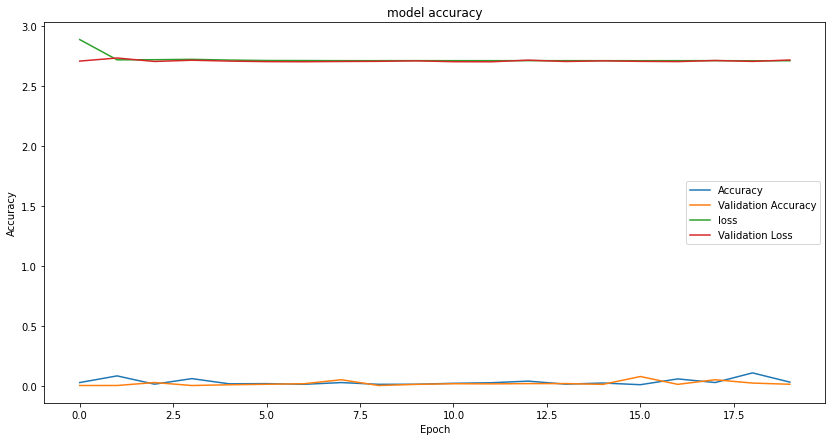

In [339]:
plotHistory(history)

# Rezultati evaluacije

In [340]:
testDataGen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

testGenerator = testDataGen.flow_from_dataframe(
    testDf,
    x_col="image_path",
    y_col="labels",
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    validate_filenames=True
)

Found 25596 validated image filenames belonging to 15 classes.


In [341]:
results = model.evaluate(testGenerator, steps=testGenerator.samples // BATCH_SIZE)

1599/1599 [==============================] - 70s 44ms/step - loss: 2.7135 - accuracy: 0.0299


In [344]:
print("Accuracy on test set: {0:.2%}".format(results[1]))

Accuracy on test set: 2.99%


# Dodatak: Neuspešan *custom* model

Isprobano je nekoliko nezavisnih modela koji nisu davali dobre rezultate tokom treniranja u 100 epoha.

In [221]:
# def create_model():
#   model = Sequential()
#   model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), strides=(1,1)))
#   model.add(Activation('relu'))
#   model.add(Conv2D(32, (3, 3), strides=(1,1)))
#   model.add(Activation('relu'))
#   model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

#   model.add(Conv2D(64, (3, 3), strides=(1,1)))
#   model.add(Activation('relu'))
#   model.add(Conv2D(64, (3, 3), strides=(1,1)))
#   model.add(Activation('relu'))
#   model.add(Conv2D(64, (3, 3), strides=(1,1)))
#   model.add(Activation('relu'))
#   model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

#   model.add(Conv2D(128, (3, 3), strides=(1,1)))
#   model.add(Activation('relu'))
#   model.add(Conv2D(128, (3, 3), strides=(1,1)))
#   model.add(Activation('relu'))
#   model.add(Conv2D(128, (3, 3), strides=(1,1)))
#   model.add(Activation('relu'))
#   model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

#   model.add(Conv2D(256, (3, 3), strides=(1,1)))
#   model.add(Activation('relu'))
#   model.add(Conv2D(256, (3, 3), strides=(1,1)))
#   model.add(Activation('relu'))
#   model.add(Conv2D(256, (3, 3), strides=(1,1)))
#   model.add(Activation('relu'))
#   model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

#   model.add(Flatten())

#   model.add(Dense(1024))
#   model.add(Activation('relu'))
#   model.add(Dropout(0.5))
  
#   model.add(Dense(1024))
#   model.add(Activation('relu'))
#   model.add(Dropout(0.5))
#   model.add(Dense(15))
#   model.add(Activation('softmax'))
  
#   return model

# create_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 146, 146, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 71, 71, 64)        0

# Dodatak: Treniranje modela na TPU

Google Colab je okruženje koje pruža hardver različitih performansi za rad. Naredni kod koji je dat pod komentarima je pokušaj konfigurisanja skupa podataka, kao i celokupnog okruženja za rad sa TPU hardverom, međutim, zbog korišćenja *ImageDataGenerator* klase, generatori su morali da budu "obavijeni" u *tensorflow* Dataset, ali je ovaj pokušaj bio neuspešan. Uvidom u *issue* sekciju Tensorflow GitHub repozitorijuma, kao i nekoliko odgovora pronađenih na StackOverflow stranici, utvrđeno je da postoji *bug* koji se javlja mnogim korisnicima i da do datuma (1.2.2021.) izrade ovog rada nije uspešno rešen. ([1](https://github.com/tensorflow/tensorflow/issues/34346), [2](https://stackoverflow.com/questions/52636127/how-to-use-keras-generator-with-tf-data-api), [**3**](https://stackoverflow.com/questions/63846264/how-to-use-tpu-on-kaggle-colab-with-imagedatagenerator))

In [15]:
# Wrapping the keras generator
# trainDS = tf.data.Dataset.from_generator(
#     lambda: trainGenerator,
#     output_types=(tf.float32, tf.float32),
#     output_shapes = ([BATCH_SIZE,224,224,3],
#                      [BATCH_SIZE,15])
#     )

# validDS = tf.data.Dataset.from_generator(
#     lambda: validGenerator,
#     output_types=(tf.float32, tf.float32),
#     output_shapes = ([BATCH_SIZE,224,224,3],
#                      [BATCH_SIZE,15])
#     )

In [16]:
# import re
# import os
# import random
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# import matplotlib.pyplot as plt

# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
# print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# strategy = tf.distribute.experimental.TPUStrategy(tpu)

# print("REPLICAS: ", strategy.num_replicas_in_sync)

In [17]:
# with strategy.scope():
#   model = create_model()
#       loss = 'categorical_crossentropy', 
#       optimizer = Adam(learning_rate=0.0001), 
#       metrics = ['accuracy'],
#       steps_per_execution = 50,
#   )